## POS tagging using modified Viterbi

### Data Preparation

In [105]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [106]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [107]:
print(len(wsj))
print(wsj[0])
wsj[0][0]

3914
[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


('Pierre', 'NOUN')

In [108]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [109]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('South', 'NOUN'), ('Africa', 'NOUN'), ('accused', 'VERB'), ('armed', 'VERB'), ('Namibian', 'ADJ'), ('nationalist', 'ADJ'), ('guerrillas', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('crossing', 'VERB'), ('from', 'ADP'), ('bases', 'NOUN'), ('in', 'ADP'), ('neighboring', 'VERB'), ('Angola', 'NOUN'), (',', '.'), ('*-1', 'X'), ('violating', 'VERB'), ('U.N.-supervised', 'ADJ'), ('peace', 'NOUN'), ('plans', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('territory', 'NOUN'), ("'s", 'PRT'), ('independence', 'NOUN'), ('from', 'ADP'), ('Pretoria', 'NOUN'), ('.', '.')], [('The', 'DET'), ('First', 'NOUN'), ('World', 'NOUN'), ('has', 'VERB'), ('for', 'ADP'), ('some', 'DET'), ('time', 'NOUN'), ('had', 'VERB'), ('the', 'DET'), ('bad', 'ADJ'), ('habit', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('smothering', 'VERB'), ('other', 'ADJ'), ('people', 'NOUN'), ("'s", 'PRT'), ('economies', 'NOUN'), ('with', 'ADP'), ('this', 'DET'), ('kind', 'NOUN'), ('of', 'ADP'), ('unfocused', 'ADJ'), ('kindness', 'NOUN'), ('.'

In [110]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95643

In [111]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['South',
 'Africa',
 'accused',
 'armed',
 'Namibian',
 'nationalist',
 'guerrillas',
 'of',
 '*',
 'crossing']

In [112]:
# vocabulary
V = set(tokens)
print(len(V))

12063


In [113]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [114]:
print(T)

{'PRT', 'ADJ', 'VERB', '.', 'CONJ', 'PRON', 'NUM', 'NOUN', 'X', 'DET', 'ADP', 'ADV'}


POS Tagging Algorithm - HMM

In [115]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [116]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [117]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [118]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [119]:
tags_matrix

array([[1.95185421e-03, 8.32791179e-02, 4.03383225e-01, 4.29407954e-02,
        2.27716332e-03, 1.65907610e-02, 5.75796999e-02, 2.46909559e-01,
        1.36629799e-02, 1.00195184e-01, 2.11450886e-02, 1.00845806e-02],
       [1.01706041e-02, 6.77493438e-02, 1.21391080e-02, 6.51246756e-02,
        1.65682416e-02, 6.56167977e-04, 2.01771650e-02, 6.99311018e-01,
        2.06692908e-02, 5.08530205e-03, 7.75918663e-02, 4.75721806e-03],
       [3.14655490e-02, 6.50236383e-02, 1.69572964e-01, 3.49531099e-02,
        5.34759369e-03, 3.53406183e-02, 2.30954047e-02, 1.10904440e-01,
        2.17701316e-01, 1.34154841e-01, 9.12965983e-02, 8.11439231e-02],
       [2.34318664e-03, 4.48810384e-02, 8.90410990e-02, 9.37274694e-02,
        5.85796684e-02, 6.52487352e-02, 8.09300616e-02, 2.20259547e-01,
        2.73972601e-02, 1.73485935e-01, 9.16546509e-02, 5.23612127e-02],
       [5.11865970e-03, 1.18659839e-01, 1.58213124e-01, 3.53652872e-02,
        4.65332705e-04, 5.72359227e-02, 4.14146110e-02, 3.46

In [120]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRT,ADJ,VERB,.,CONJ,PRON,NUM,NOUN,X,DET,ADP,ADV
PRT,0.001952,0.083279,0.403383,0.042941,0.002277,0.016591,0.057580,0.246910,0.013663,0.100195,0.021145,0.010085
ADJ,0.010171,0.067749,0.012139,0.065125,0.016568,0.000656,0.020177,0.699311,0.020669,0.005085,0.077592,0.004757
VERB,0.031466,0.065024,0.169573,0.034953,0.005348,0.035341,0.023095,0.110904,0.217701,0.134155,0.091297,0.081144
.,0.002343,0.044881,0.089041,0.093727,0.058580,0.065249,0.080930,0.220260,0.027397,0.173486,0.091655,0.052361
CONJ,0.005119,0.118660,0.158213,0.035365,0.000465,0.057236,0.041415,0.346208,0.008841,0.120987,0.052583,0.054909
PRON,0.013158,0.071981,0.488390,0.041022,0.005418,0.007740,0.007353,0.207043,0.092879,0.008514,0.022833,0.033669
NUM,0.027490,0.031924,0.018918,0.116465,0.013597,0.001478,0.184747,0.355306,0.208691,0.002956,0.035471,0.002956
NOUN,0.043907,0.012409,0.146721,0.239388,0.042556,0.004781,0.009599,0.264499,0.029417,0.013358,0.176028,0.017336
X,0.186715,0.017162,0.203083,0.161926,0.010170,0.055617,0.002860,0.062609,0.074845,0.053710,0.145559,0.025743
DET,0.000241,0.205308,0.039807,0.018215,0.000483,0.003498,0.022075,0.637274,0.045235,0.005790,0.009409,0.012666


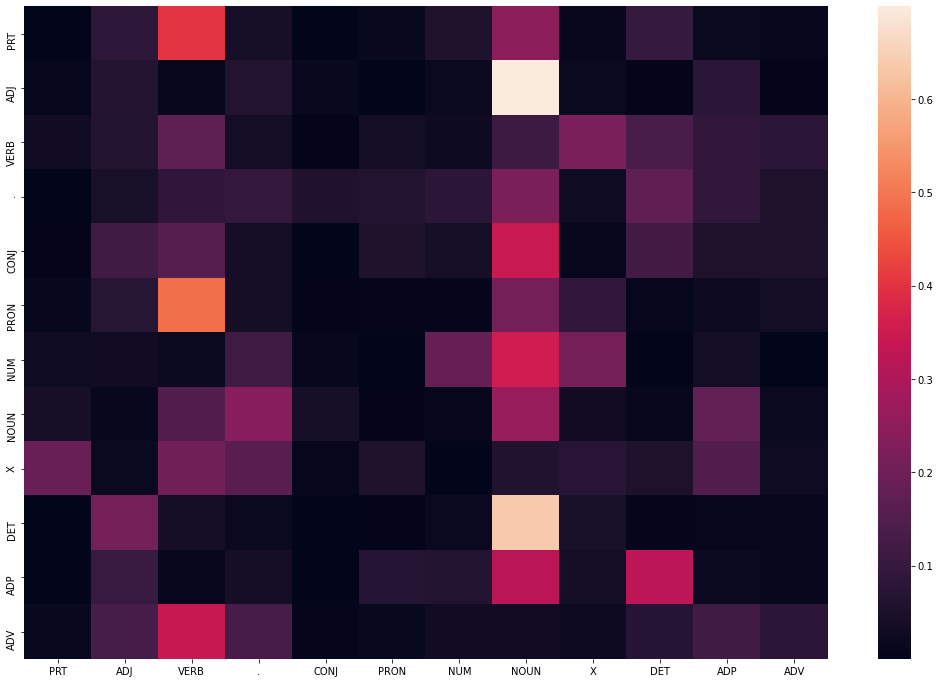

In [121]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


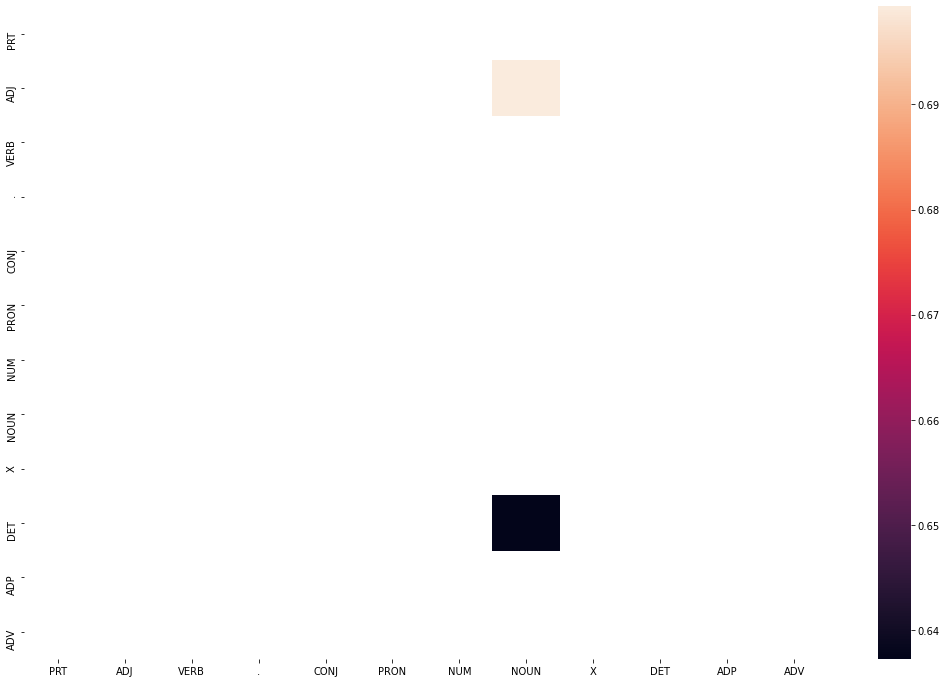

In [122]:
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [123]:
#Get the total length of tagged words in training corpus
len(train_tagged_words)

95643

### Build the vanilla Viterbi based POS tagger

In [124]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [125]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('How', 'ADV'),
  ("'s", 'VERB'),
  ('that', 'DET'),
  ('*T*-1', 'X'),
  ('again', 'ADV'),
  ('?', '.')],
 [('Bob', 'NOUN'),
  ('has', 'VERB'),
  ('an', 'DET'),
  ('agenda', 'NOUN'),
  ('and', 'CONJ'),
  ('this', 'DET'),
  ('seemed', 'VERB'),
  ('like', 'ADP'),
  ('the', 'DET'),
  ('natural', 'ADJ'),
  ('time', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('The', 'DET'),
  ('U.S.', 'NOUN'),
  ('and', 'CONJ'),
  ('Soviet', 'NOUN'),
  ('Union', 'NOUN'),
  ('are', 'VERB'),
  ('holding', 'VERB'),
  ('technical', 'ADJ'),
  ('talks', 'NOUN'),
  ('about', 'ADP'),
  ('possible', 'ADJ'),
  ('repayment', 'NOUN'),
  ('by', 'ADP'),
  ('Moscow', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('188', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('pre-Communist', 'ADJ'),
  ('Russian', 'ADJ'),
  ('debts', 'NOUN'),
  ('owed', 'VERB'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('the', 'DET'),
  ('U.S.', 'NOUN'),
  ('government', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('State', 'NOUN'),
  ('Depar

In [126]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  26.01344585418701
[('How', 'ADV'), ("'s", 'PRT'), ('that', 'DET'), ('*T*-1', 'X'), ('again', 'ADV'), ('?', '.'), ('Bob', 'NOUN'), ('has', 'VERB'), ('an', 'DET'), ('agenda', 'NOUN'), ('and', 'CONJ'), ('this', 'DET'), ('seemed', 'VERB'), ('like', 'ADP'), ('the', 'DET'), ('natural', 'ADJ'), ('time', 'NOUN'), ('.', '.'), ("''", '.'), ('The', 'DET'), ('U.S.', 'NOUN'), ('and', 'CONJ'), ('Soviet', 'ADJ'), ('Union', 'NOUN'), ('are', 'VERB'), ('holding', 'VERB'), ('technical', 'ADJ'), ('talks', 'NOUN'), ('about', 'ADP'), ('possible', 'ADJ'), ('repayment', 'PRT'), ('by', 'ADP'), ('Moscow', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('188', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('pre-Communist', 'PRT'), ('Russian', 'PRT'), ('debts', 'NOUN'), ('owed', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('the', 'DET'), ('U.S.', 'NOUN'), ('government', 'NOUN'), (',', '.'), ('the', 'DET'), ('State', 'NOUN'), ('Department', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.

In [127]:

# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(round(accuracy*100,2),"%")

93.69 %


In [128]:
import urllib.request

lines=[]
for line in urllib.request.urlopen('https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt'):
    line=str(line)[2:-5] # Removing the junk characters
    if(len(line)>0):
      print(line)
      lines.append(line)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.


### Solve the problem of unknown words

In [129]:
lines
test_lines=lines

In [130]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('How', 'ADV'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('and', 'CONJ'), (('Soviet', 'ADJ'), ('Soviet', 'NOUN'))],
 [('possible', 'ADJ'), (('repayment', 'PRT'), ('repayment', 'NOUN'))],
 [('in', 'ADP'), (('pre-Communist', 'PRT'), ('pre-Communist', 'ADJ'))],
 [('pre-Communist', 'ADJ'), (('Russian', 'PRT'), ('Russian', 'ADJ'))],
 [('--', '.'), (('the', 'DET'), ('the', 'NUM'))],
 [('$', '.'), (('1.9', 'PRT'), ('1.9', 'NUM'))]]

In [131]:
nltk.download('punkt')
#Get the predictions on the test sentences
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Android', 'PRT'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRT'),
 ('.', '.'),
 ('Android', 'PRT'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('on', 'ADP'),
 ('smartphones', 'PRT'),
 ('since', 'ADP'),
 ('2011', 'PRT'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRT'),
 ('.', '.'),
 ('Google', 'PRT'),
 ('and', 'CONJ'),
 ('Twitter', 'PRT'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRT'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'PRT'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRT'),
 ("'s", 'VERB'),
 ('firehose', 'PRT'),
 ('.', '.'),
 ('Twitter', 'PRT'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRT'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NO

In [132]:
#Get the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [133]:

#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['21st',
 'domineering',
 'trips',
 'Google',
 'OS',
 'invited',
 '2015',
 'ICESAT-2',
 'arriving',
 'messages',
 'tournament',
 '2018',
 'firehose',
 'NASA',
 'Twitter',
 'personality',
 '2013',
 'online',
 'worldwide',
 'smartphones',
 'interact',
 'FIFA',
 '2011',
 'tweets',
 'contested',
 'Satellite',
 'Android',
 'Cup']

In [134]:

#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]


[('Android', 'PRT'),
 ('Google', 'PRT'),
 ('Android', 'PRT'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('smartphones', 'PRT'),
 ('2011', 'PRT'),
 ('2013', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('2015', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('firehose', 'PRT'),
 ('Twitter', 'PRT'),
 ('online', 'PRT'),
 ('interact', 'PRT'),
 ('messages', 'PRT'),
 ('tweets', 'PRT'),
 ('domineering', 'PRT'),
 ('personality', 'PRT'),
 ('2018', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('21st', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('tournament', 'PRT'),
 ('contested', 'PRT'),
 ('Cup', 'PRT'),
 ('trips', 'PRT'),
 ('arriving', 'PRT'),
 ('NASA', 'PRT'),
 ('invited', 'PRT'),
 ('ICESAT-2', 'PRT'),
 ('Satellite', 'PRT')]

The words which are not in courpos are tagged as PRT ( participles ) becuase ther is no calculation for prior probabaility

In [135]:

#Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'.': 11096,
         'ADJ': 6096,
         'ADP': 9359,
         'ADV': 3017,
         'CONJ': 2149,
         'DET': 8290,
         'NOUN': 27399,
         'NUM': 3383,
         'PRON': 2584,
         'PRT': 3074,
         'VERB': 12903,
         'X': 6293})

In [136]:
# see most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27399), ('VERB', 12903), ('.', 11096), ('ADP', 9359), ('DET', 8290)]

In [137]:
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADJ': 1, 'DET': 1, 'PRT': 5})

In [138]:

# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.2076261334573355


[('accused', 'VERB'),
 ('armed', 'VERB'),
 ('formed', 'VERB'),
 ('imported', 'VERB'),
 ('raised', 'VERB'),
 ('pulled', 'VERB'),
 ('approved', 'VERB'),
 ('rusted', 'VERB'),
 ('fined', 'VERB'),
 ('spooked', 'VERB'),
 ('led', 'VERB'),
 ('threatened', 'VERB'),
 ('passed', 'VERB'),
 ('designed', 'VERB'),
 ('expressed', 'VERB'),
 ('retraced', 'VERB'),
 ('opposed', 'VERB'),
 ('mollified', 'VERB'),
 ('imposed', 'VERB'),
 ('proposed', 'VERB')]

In [139]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6096
4263
0.6993110236220472


In [140]:
#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8290
5283
0.6372738238841978


In [141]:

#Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3017
1038
0.344050381173351


In [142]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [143]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9509239022451818

#### Evaluating tagging accuracy

In [144]:

#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [145]:
#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

In [146]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [147]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

27.21277403831482


In [148]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
print(round(accuracy*100,2),"%")

95.5 %


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [149]:
#Let us print the test lines with the initial Viterbi algorithm
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.')]
[('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.')]
[('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ("'s", 'VERB'), ('firehose', 'PRT'), ('.', '.')]
[('Twitter', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRT'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 

In [150]:
#Let us print the test lines with the updated Viterbi algorithm
for line in test_lines:
    print(list(Viterbi_updated(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

Here you can see that the words like Android, Google and Twitter were tagged as PRT incorrectly but now they have been correctly classified as NOUN

In [151]:
# Viterbi Heuristic
def Viterbi_updated2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [152]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated2(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

25.89185857772827


In [153]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
print(round(accuracy*100,2),"%")

95.5 %
